In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
products = pd.read_csv('data/amazon_baby_subset.csv')
important_words = pd.read_json('data/important_words.json')[0]

In [4]:
def remove_punctuation(text):
    import string
    # first parameter should be translate table
    return text.translate(str.maketrans('', '', string.punctuation))


def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = np.concatenate((['constant'], features))
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)


def predict_probability(feature_matrix, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-scores))
    return predictions


def predict_sentiment(feature_matrix, coefficients):
    return (np.dot(feature_matrix, coefficients)>=0)*2-1


def feature_derivative(errors: np.ndarray, feature: np.ndarray):
    derivative = (errors*feature).sum()
    return derivative


def feature_derivative_l2(errors: np.ndarray, feature: np.ndarray, coefficients, l2_penalty, feature_is_constant):
    if feature_is_constant:
        return (errors*feature).sum()
    derivative = (errors*feature).sum()-2*l2_penalty*coefficients
    return derivative


def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==1)
    scores = np.dot(feature_matrix, coefficients)
    ll = ((indicator-1)*scores-np.log(1.+np.exp(-scores))).sum()
    return ll


def compute_log_likelihood_l2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==1)
    scores = np.dot(feature_matrix, coefficients)
    ll = ((indicator-1)*scores-np.log(1.+np.exp(-scores))).sum() -l2_penalty*np.sum(coefficients[1:]**2)
    return ll


def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w)
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==1)
        errors = indicator - predictions
        
#         print learning situation
        for j in range(len(coefficients)):
            derivative = feature_derivative(errors, feature_matrix[:,j])
            coefficients[j] += step_size*derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients


def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w)
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==1)
        errors = indicator - predictions
        
        for j in range(len(coefficients)):
            if j==0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_l2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, feature_is_constant)
            coefficients[j] += step_size*derivative

        # print log likelihood of learning
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_l2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    print(l2_penalty)
    return coefficients
    

def score_to_lebel(score: np.ndarray):
    return score > 0


def score_to_probability(score: np.ndarray):
    return 1/(1+np.exp(-score))


def accur(y, y_predict):
    true_pre = (y == y_predict).sum()
    total = len(y)
    return true_pre/total

In [62]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    return compute_log_likelihood(feature_matrix,sentiment,coefficients)/len(sentiment)


def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    coefficients = np.array(initial_coefficients)
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    B = batch_size

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix[i:i+B,:], coefficients)
        indicator = (sentiment_train[i:i+B]==+1)

        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+B,j])
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            coefficients[j] += step_size*derivative/B

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [5]:
products = products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s:s.split().count(word))


In [8]:
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment')
feature_matrix.shape

(53072, 194)

In [58]:
train_data = pd.read_json('data/module-10-assignment-train-idx.json')[0]
validation_data = pd.read_json('data/module-10-assignment-validation-idx.json')[0]

feature_matrix_train, sentiment_train = get_numpy_data(products.loc[train_data,:], important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(products.loc[validation_data,:], important_words, 'sentiment') 

In [20]:
feature_matrix_train[i:i+1,j]

array([0], dtype=int64)

In [21]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.5
           --> Should print 0.0


In [23]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [47]:
sentiment.shape

(42361, 194)

In [30]:

initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10
coefficients = logistic_regression_SG(feature_matrix_train, sentiment, initial_coefficients, step_size, 1, max_iter)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.00000000
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -2.64976287
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.00182308
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.21973730
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.05179512
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.03103701
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -1.91509033
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -4.52970758
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.01515679
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.06261301


In [32]:
coefficients = logistic_regression_SG(feature_matrix_train, sentiment, initial_coefficients, 
                                      step_size, feature_matrix_train.shape[0], 200)

Iteration   0: Average log likelihood (of data points  [00000:42361]) = -0.69290329
Iteration   1: Average log likelihood (of data points  [00000:42361]) = -0.69245883
Iteration   2: Average log likelihood (of data points  [00000:42361]) = -0.69205390
Iteration   3: Average log likelihood (of data points  [00000:42361]) = -0.69188386
Iteration   4: Average log likelihood (of data points  [00000:42361]) = -0.69203154
Iteration   5: Average log likelihood (of data points  [00000:42361]) = -0.69215587
Iteration   6: Average log likelihood (of data points  [00000:42361]) = -0.69267159
Iteration   7: Average log likelihood (of data points  [00000:42361]) = -0.69227316
Iteration   8: Average log likelihood (of data points  [00000:42361]) = -0.69261154
Iteration   9: Average log likelihood (of data points  [00000:42361]) = -0.69195963
Iteration  10: Average log likelihood (of data points  [00000:42361]) = -0.69209273
Iteration  11: Average log likelihood (of data points  [00000:42361]) = -0.6

In [69]:
step_size=1e-1
batch_size=100
coefficients, log_likelyhood_all = logistic_regression_SG(feature_matrix_train, sentiment, initial_coefficients, 
                                      step_size, batch_size, 200)

Iteration   0: Average log likelihood (of data points  [00000:00100]) = -0.70179315
Iteration   1: Average log likelihood (of data points  [00100:00200]) = -0.70612213
Iteration   2: Average log likelihood (of data points  [00200:00300]) = -0.68869708
Iteration   3: Average log likelihood (of data points  [00300:00400]) = -0.79181871
Iteration   4: Average log likelihood (of data points  [00400:00500]) = -0.69853669
Iteration   5: Average log likelihood (of data points  [00500:00600]) = -0.68661407
Iteration   6: Average log likelihood (of data points  [00600:00700]) = -0.81361286
Iteration   7: Average log likelihood (of data points  [00700:00800]) = -0.75640852
Iteration   8: Average log likelihood (of data points  [00800:00900]) = -0.74190640
Iteration   9: Average log likelihood (of data points  [00900:01000]) = -0.76743489
Iteration  10: Average log likelihood (of data points  [01000:01100]) = -0.82682806
Iteration  11: Average log likelihood (of data points  [01100:01200]) = -0.8

No handles with labels found to put in legend.


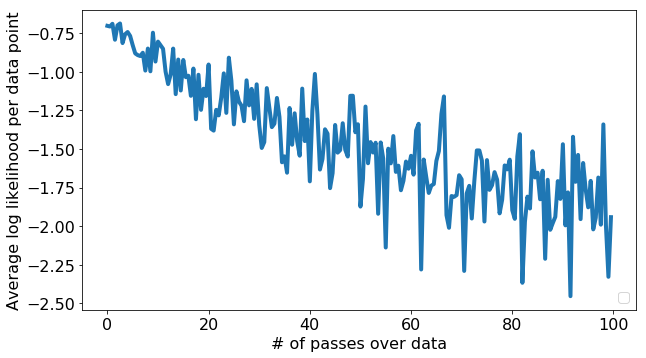

In [75]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})
    
make_plot(log_likelyhood_all, 200, batch_size)


Iteration   0: Average log likelihood (of data points  [00000:00100]) = -0.69517277
Iteration   1: Average log likelihood (of data points  [00100:00200]) = -0.73517047
Iteration   2: Average log likelihood (of data points  [00200:00300]) = -0.74725036
Iteration   3: Average log likelihood (of data points  [00300:00400]) = -0.71304466
Iteration   4: Average log likelihood (of data points  [00400:00500]) = -0.76299564
Iteration   5: Average log likelihood (of data points  [00500:00600]) = -0.80620934
Iteration   6: Average log likelihood (of data points  [00600:00700]) = -0.75739197
Iteration   7: Average log likelihood (of data points  [00700:00800]) = -0.77873618
Iteration   8: Average log likelihood (of data points  [00800:00900]) = -0.82335643
Iteration   9: Average log likelihood (of data points  [00900:01000]) = -0.88033386
Iteration  10: Average log likelihood (of data points  [01000:01100]) = -0.84128838
Iteration  11: Average log likelihood (of data points  [01100:01200]) = -0.8

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Iteration 199: Average log likelihood (of data points  [00000:42361]) = -0.69319098


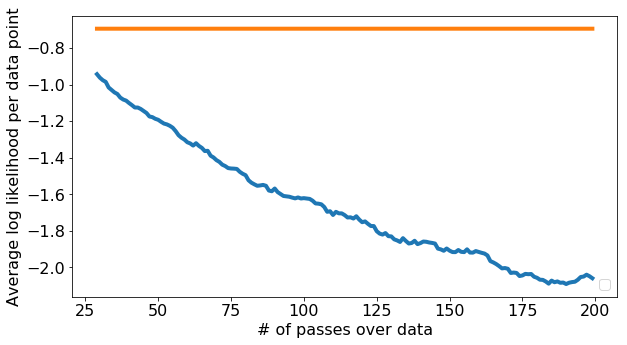

In [50]:
step_size = 0.1
batch_size=100
s_coefficients, s_log_likelyhood_all = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, 
                                      step_size, batch_size, 200)


initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = feature_matrix_train.shape[0]
b_coefficients, b_log_likelyhood_all = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, 
                                      step_size, batch_size, 200)

make_plot(s_log_likelyhood_all, feature_matrix_train.shape[0], batch_size, 30)
make_plot(b_log_likelyhood_all, feature_matrix_train.shape[0], batch_size, 30)

Iteration 0: Average log likelihood (of data points  [00000:00100]) = -0.69315899
Iteration 1: Average log likelihood (of data points  [00100:00200]) = -0.69317103
Iteration 2: Average log likelihood (of data points  [00200:00300]) = -0.69313844
Iteration 3: Average log likelihood (of data points  [00300:00400]) = -0.69320893
Iteration 4: Average log likelihood (of data points  [00400:00500]) = -0.69312343
Iteration 5: Average log likelihood (of data points  [00500:00600]) = -0.69313359
Iteration 6: Average log likelihood (of data points  [00600:00700]) = -0.69319954
Iteration 7: Average log likelihood (of data points  [00700:00800]) = -0.69310194
Iteration 8: Average log likelihood (of data points  [00800:00900]) = -0.69313875
Iteration 9: Average log likelihood (of data points  [00900:01000]) = -0.69311765
Iteration 0: Average log likelihood (of data points  [00000:00100]) = -0.69326587
Iteration 1: Average log likelihood (of data points  [00100:00200]) = -0.69338699
Iteration 2: Ave

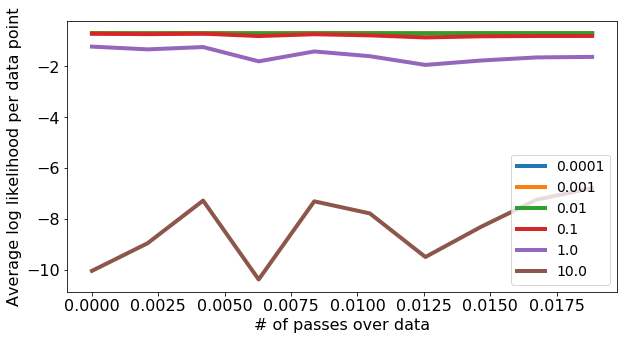

In [86]:
step_sizes = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
batch_size=100
for size in step_sizes:
    b_coefficients, b_log_likelyhood_all = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, 
                                      size, batch_size, 10)
    make_plot(b_log_likelyhood_all, train_data.shape[0], batch_size,label=str(size))

No handles with labels found to put in legend.


Iteration 0: Average log likelihood (of data points  [00000:00100]) = -100.36000000
Iteration 1: Average log likelihood (of data points  [00100:00200]) = -89.50500000
Iteration 2: Average log likelihood (of data points  [00200:00300]) = -72.70500000
Iteration 3: Average log likelihood (of data points  [00300:00400]) = -103.71000000
Iteration 4: Average log likelihood (of data points  [00400:00500]) = -72.97000000
Iteration 5: Average log likelihood (of data points  [00500:00600]) = -77.70000000
Iteration 6: Average log likelihood (of data points  [00600:00700]) = -94.81500000
Iteration 7: Average log likelihood (of data points  [00700:00800]) = -82.95000000
Iteration 8: Average log likelihood (of data points  [00800:00900]) = -72.28000000
Iteration 9: Average log likelihood (of data points  [00900:01000]) = -67.64500000


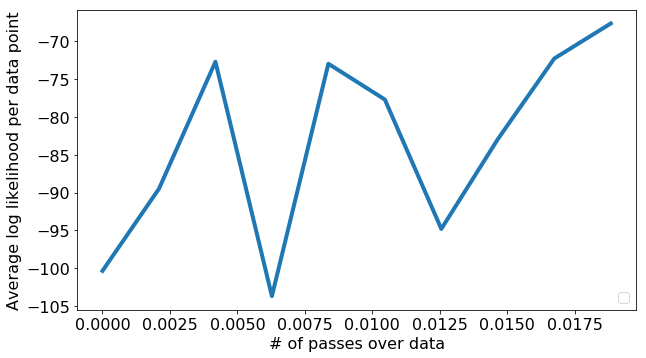

In [82]:
b_coefficients, b_log_likelyhood_all = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, 
                                      1e2, batch_size, 10)
make_plot(b_log_likelyhood_all, train_data.shape[0], batch_size)